<a href="https://colab.research.google.com/github/tcdev2021/explainable-energy-demand-forecasting/blob/main/explainable_energy_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project name: Energy Forecasting & Explainable Decision Support (Norway)
Summary of this project is at the bottom.

Step 1 — Persist everything in Google Drive (project foundation)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


1.2 Create the project folder structure in Drive

In [ ]:
import pathlib

ROOT = pathlib.Path("/content/drive/MyDrive/volt_age_projects")
PROJECT = ROOT / "project1_energy_forecasting_xai"

for p in [
    PROJECT/"data/raw",
    PROJECT/"data/processed",
    PROJECT/"notebooks",
    PROJECT/"reports",
    PROJECT/"src"
]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT)


Project root: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai


1.3 (Optional but recommended) Confirm it exists

In [ ]:
!ls -la "/content/drive/MyDrive/volt_age_projects"


total 4
drwx------ 6 root root 4096 Feb 19 02:35 project1_energy_forecasting_xai


Step 2 — Download OPSD dataset into Google Drive..
We now ingest the Open Power System Data (time series) dataset and save it inside your project.

2.1 Download + save to data/raw

In [ ]:
import pandas as pd

url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

raw_path = PROJECT / "data/raw/time_series_60min_singleindex.csv"

# Download and save
df = pd.read_csv(url)
df.to_csv(raw_path, index=False)

print("Saved to:", raw_path)
print("Shape:", df.shape)

df.head(3)


Saved to: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/data/raw/time_series_60min_singleindex.csv
Shape: (50401, 300)


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN


2.2 Inspect columns related to Norway (important discovery step)...
This shows:

Norway load

Price

Forecast load

Possibly generation signals

We need this to choose the target variable.

In [ ]:
cols = df.columns.tolist()

no_cols = [c for c in cols if c.startswith("NO_") or "_NO_" in c]

len(no_cols), no_cols[:50]


(23,
 ['NO_load_actual_entsoe_transparency',
  'NO_load_forecast_entsoe_transparency',
  'NO_wind_onshore_generation_actual',
  'NO_1_load_actual_entsoe_transparency',
  'NO_1_load_forecast_entsoe_transparency',
  'NO_1_price_day_ahead',
  'NO_1_wind_onshore_generation_actual',
  'NO_2_load_actual_entsoe_transparency',
  'NO_2_load_forecast_entsoe_transparency',
  'NO_2_price_day_ahead',
  'NO_2_wind_onshore_generation_actual',
  'NO_3_load_actual_entsoe_transparency',
  'NO_3_load_forecast_entsoe_transparency',
  'NO_3_price_day_ahead',
  'NO_3_wind_onshore_generation_actual',
  'NO_4_load_actual_entsoe_transparency',
  'NO_4_load_forecast_entsoe_transparency',
  'NO_4_price_day_ahead',
  'NO_4_wind_onshore_generation_actual',
  'NO_5_load_actual_entsoe_transparency',
  'NO_5_load_forecast_entsoe_transparency',
  'NO_5_price_day_ahead',
  'NO_5_wind_onshore_generation_actual'])

Step 3 — Build the Norway load dataset (first model-ready table)..
Now we create a clean time-series dataset with:

Proper datetime index

Norway electricity load (target)

Only useful columns

Missing values handled

3.1 Convert time column → datetime index

In [ ]:
df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"])
df = df.set_index("utc_timestamp").sort_index()

df.head()


,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


3.2 Identify the main Norway load column...
You will see something like:

NO_load_actual

NO_load_forecast

👉 We want actual load as target.

In [ ]:
[c for c in df.columns if "load" in c.lower() and "NO" in c]


['IT_CNOR_load_actual_entsoe_transparency',
 'IT_CNOR_load_forecast_entsoe_transparency',
 'IT_NORD_load_actual_entsoe_transparency',
 'IT_NORD_load_forecast_entsoe_transparency',
 'NO_load_actual_entsoe_transparency',
 'NO_load_forecast_entsoe_transparency',
 'NO_1_load_actual_entsoe_transparency',
 'NO_1_load_forecast_entsoe_transparency',
 'NO_2_load_actual_entsoe_transparency',
 'NO_2_load_forecast_entsoe_transparency',
 'NO_3_load_actual_entsoe_transparency',
 'NO_3_load_forecast_entsoe_transparency',
 'NO_4_load_actual_entsoe_transparency',
 'NO_4_load_forecast_entsoe_transparency',
 'NO_5_load_actual_entsoe_transparency',
 'NO_5_load_forecast_entsoe_transparency']

3.3 Create the modeling dataframe (target only first)

In [ ]:
target_col = [c for c in df.columns if "NO_load_actual" in c][0]

data = df[[target_col]].copy()
data = data.rename(columns={target_col: "load_MW"})

print(data.shape)
data.head()


(50401, 1)


,load_MW
utc_timestamp,
2014-12-31 23:00:00+00:00,NaN
2015-01-01 00:00:00+00:00,NaN
2015-01-01 01:00:00+00:00,15104.99
2015-01-01 02:00:00+00:00,14882.56
2015-01-01 03:00:00+00:00,14755.09


3.4 Handle missing values (important)

In [ ]:
data["load_MW"] = data["load_MW"].interpolate(limit_direction="both")

data.isna().sum()


,0
load_MW,0


3.5 Save processed dataset

In [ ]:
processed_path = PROJECT / "data/processed/norway_load.csv"
data.to_csv(processed_path)

print("Saved:", processed_path)


Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/data/processed/norway_load.csv


Step 4 — Create time features (core for forecasting + XAI)

Time features are extremely important because electricity demand strongly depends on:

Hour of day

Day of week

Season

Holidays (later)

These features also make SHAP explanations meaningful.

4.1 Load processed dataset (good reproducible habit)

In [ ]:
import pandas as pd

data = pd.read_csv(PROJECT / "data/processed/norway_load.csv", index_col=0, parse_dates=True)

data.head()


,load_MW
utc_timestamp,
2014-12-31 23:00:00+00:00,15104.99
2015-01-01 00:00:00+00:00,15104.99
2015-01-01 01:00:00+00:00,15104.99
2015-01-01 02:00:00+00:00,14882.56
2015-01-01 03:00:00+00:00,14755.09


4.2 Create basic calendar features

In [ ]:
data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["weekofyear"] = data.index.isocalendar().week.astype(int)
data["year"] = data.index.year

data.head()


,load_MW,hour,dayofweek,month,weekofyear,year
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,15104.99,23,2,12,1,2014
2015-01-01 00:00:00+00:00,15104.99,0,3,1,1,2015
2015-01-01 01:00:00+00:00,15104.99,1,3,1,1,2015
2015-01-01 02:00:00+00:00,14882.56,2,3,1,1,2015
2015-01-01 03:00:00+00:00,14755.09,3,3,1,1,2015


4.3 Add cyclic encoding (VERY important for ML + XAI)

Models understand cycles better with sin/cos.

In [ ]:
import numpy as np

data["hour_sin"] = np.sin(2*np.pi*data["hour"]/24)
data["hour_cos"] = np.cos(2*np.pi*data["hour"]/24)

data["dow_sin"] = np.sin(2*np.pi*data["dayofweek"]/7)
data["dow_cos"] = np.cos(2*np.pi*data["dayofweek"]/7)

data["month_sin"] = np.sin(2*np.pi*data["month"]/12)
data["month_cos"] = np.cos(2*np.pi*data["month"]/12)

data.head()


,load_MW,hour,dayofweek,month,weekofyear,year,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
utc_timestamp,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,15104.99,23,2,12,1,2014,-0.258819,0.965926,0.974928,-0.222521,-2.449294e-16,1.000000
2015-01-01 00:00:00+00:00,15104.99,0,3,1,1,2015,0.000000,1.000000,0.433884,-0.900969,5.000000e-01,0.866025
2015-01-01 01:00:00+00:00,15104.99,1,3,1,1,2015,0.258819,0.965926,0.433884,-0.900969,5.000000e-01,0.866025
2015-01-01 02:00:00+00:00,14882.56,2,3,1,1,2015,0.500000,0.866025,0.433884,-0.900969,5.000000e-01,0.866025
2015-01-01 03:00:00+00:00,14755.09,3,3,1,1,2015,0.707107,0.707107,0.433884,-0.900969,5.000000e-01,0.866025


4.4 Save updated dataset

In [ ]:
data.to_csv(PROJECT / "data/processed/norway_load_features_v1.csv")


Step 5 — Create lag features (MOST IMPORTANT for forecasting)

Lag features tell the model:

“What happened before?”

Electricity demand depends heavily on previous hours/days.

This step is critical for both XGBoost and deep models.

5.1 Load feature dataset

In [ ]:
import pandas as pd

data = pd.read_csv(
    PROJECT / "data/processed/norway_load_features_v1.csv",
    index_col=0,
    parse_dates=True
)


5.2 Create key lag features

We add:

1 hour ago

24 hours ago (daily pattern)

7 days ago (weekly pattern)

In [ ]:
data["lag_1h"] = data["load_MW"].shift(1)
data["lag_24h"] = data["load_MW"].shift(24)
data["lag_7d"] = data["load_MW"].shift(24*7)


5.3 Rolling statistics (very powerful)

These capture short-term trends.

In [ ]:
data["rolling_24h_mean"] = data["load_MW"].rolling(24).mean()
data["rolling_7d_mean"] = data["load_MW"].rolling(24*7).mean()


5.4 Remove initial NaNs (created by lags)

In [ ]:
data = data.dropna()

data.shape


(50233, 17)

5.5 Save modeling dataset

In [ ]:
data.to_csv(PROJECT / "data/processed/norway_load_model_ready_v1.csv")


Step 6 — Time-series train / validation / test split (correct way)

We must not shuffle time series.

We split chronologically:

Train → past

Validation → model tuning

Test → final evaluation

This is the professional workflow.

6.1 Load model-ready dataset

In [ ]:
import pandas as pd

data = pd.read_csv(
    PROJECT / "data/processed/norway_load_model_ready_v1.csv",
    index_col=0,
    parse_dates=True
)

data.shape


(50233, 17)

6.2 Define target + features

In [ ]:
target = "load_MW"
features = [c for c in data.columns if c != target]

X = data[features]
y = data[target]


6.3 Time split (70 / 15 / 15)

In [ ]:
n = len(data)

train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(X_train.shape, X_val.shape, X_test.shape)


(35163, 16) (7535, 16) (7535, 16)


6.4 Save splits (good reproducibility habit)

In [ ]:
X_train.to_csv(PROJECT / "data/processed/X_train.csv")
y_train.to_csv(PROJECT / "data/processed/y_train.csv")

X_val.to_csv(PROJECT / "data/processed/X_val.csv")
y_val.to_csv(PROJECT / "data/processed/y_val.csv")

X_test.to_csv(PROJECT / "data/processed/X_test.csv")
y_test.to_csv(PROJECT / "data/processed/y_test.csv")


Step 7 — Train XGBoost baseline model (first real model)

This is a major milestone.

XGBoost is:

Industry standard

Very strong baseline

Works great with tabular time features

Perfect for SHAP (XAI later)

7.1 Install XGBoost (Colab)

In [ ]:
!pip install xgboost


7.2 Load train / validation data

In [ ]:
import pandas as pd

X_train = pd.read_csv(PROJECT / "data/processed/X_train.csv", index_col=0)
y_train = pd.read_csv(PROJECT / "data/processed/y_train.csv", index_col=0).squeeze()

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)
y_val = pd.read_csv(PROJECT / "data/processed/y_val.csv", index_col=0).squeeze()


7.3 Train the baseline model

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

7.4 Quick validation prediction

In [ ]:
val_pred = model.predict(X_val)

val_pred[:5]


array([16331.618, 16431.496, 16662.494, 17245.654, 17758.684],
      dtype=float32)

7.5 Save model (important)

In [ ]:
import joblib

joblib.dump(model, PROJECT / "src/xgb_baseline.joblib")


['/content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/src/xgb_baseline.joblib']

Step 8 — Evaluate forecasting model (first real results)

This step produces:

Metrics for your report

First visualization

Baseline benchmark

Very important academically.

8.1 Load validation predictions (or recompute)

In [ ]:
import joblib
import pandas as pd

model = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)
y_val = pd.read_csv(PROJECT / "data/processed/y_val.csv", index_col=0).squeeze()

val_pred = model.predict(X_val)


8.2 Compute metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mape = np.mean(np.abs((y_val - val_pred) / y_val)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 124.22966388468932
RMSE: 206.45413126614858
MAPE: 0.8533046715148416


8.3 Plot predictions vs actual (very important)

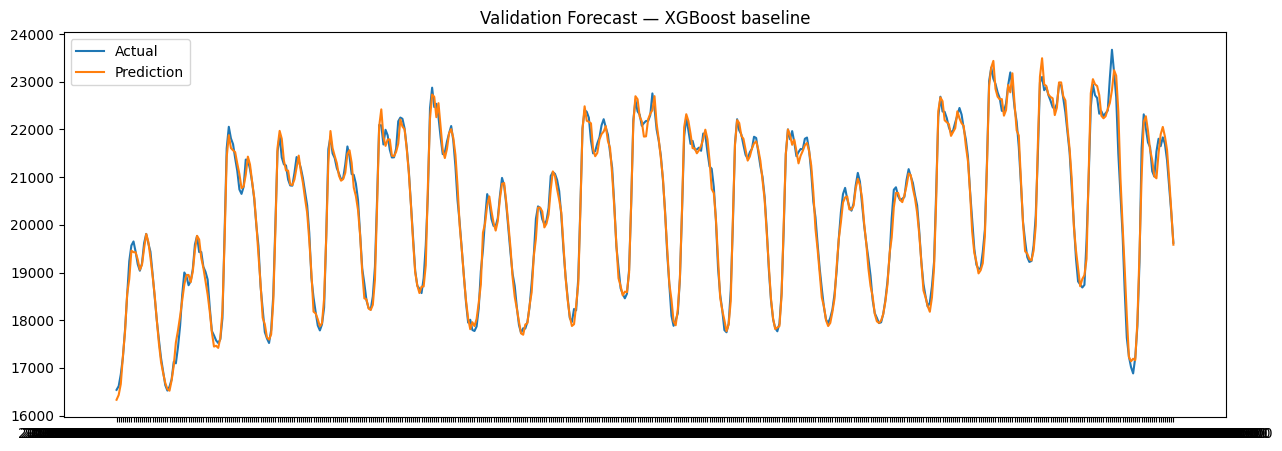

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.plot(y_val.index[:500], y_val.values[:500], label="Actual")
plt.plot(y_val.index[:500], val_pred[:500], label="Prediction")

plt.legend()
plt.title("Validation Forecast — XGBoost baseline")
plt.show()


8.4 Save metrics (professional habit)

In [ ]:
metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
}

import json
with open(PROJECT / "reports/xgb_baseline_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)


Step 9 — Add SHAP explainability (CORE of the project)

This is your main differentiator.

We will answer:

What drives energy demand?

Which features matter most?

Why did the model predict this hour?

This is exactly what Volt-Age wants.

In [ ]:
!pip install shap


9.2 Load model + data

In [ ]:
import shap
import joblib
import pandas as pd

model = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)


9.3 Create SHAP explainer

In [ ]:
explainer = shap.TreeExplainer(model)

# Use a subset (faster)
X_sample = X_val.sample(1000, random_state=42)

shap_values = explainer.shap_values(X_sample)


9.4 Global feature importance (VERY important plot)

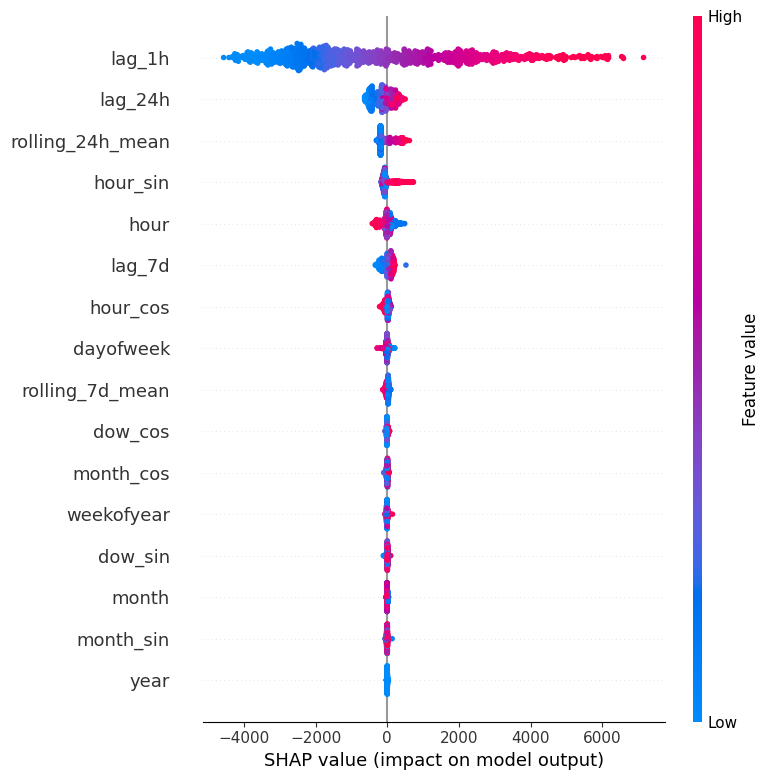

In [ ]:
shap.summary_plot(shap_values, X_sample)


9.5 Example: explain one prediction (local explanation)

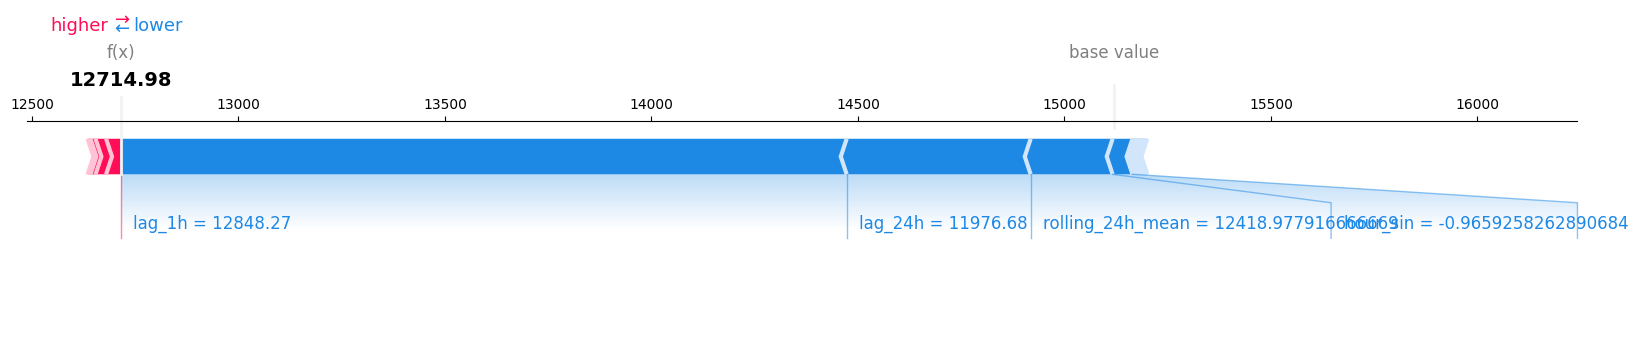

In [ ]:
idx = 10

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_sample.iloc[idx],
    matplotlib=True
)


Step 10 — Add “Decision Impact” layer (cost + carbon) on top of forecasts

This step turns your forecasting + XAI into a decision-support project: what do prediction errors mean in NOK and CO₂?

We’ll do it in a robust way:

If OPSD already contains Norway price / CO₂ intensity columns → use them.

If not → use a simple tariff + carbon assumption (still valid, and we’ll upgrade later).

OPSD time series package includes load + (for a subset of countries) prices and other series.

10.1 Load model + validation set + predictions

In [ ]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)
y_val = pd.read_csv(PROJECT / "data/processed/y_val.csv", index_col=0).squeeze()

# Keep a datetime index for joining with any price/emissions series later
X_val.index = pd.to_datetime(X_val.index)
y_val.index = pd.to_datetime(y_val.index)

val_pred = pd.Series(model.predict(X_val), index=X_val.index, name="pred_load_MW")


10.2 Build an hourly price series (use OPSD if available, else simple tariff)

In [ ]:
# Load raw OPSD (we saved it earlier)
raw = pd.read_csv(PROJECT / "data/raw/time_series_60min_singleindex.csv")
raw["utc_timestamp"] = pd.to_datetime(raw["utc_timestamp"])
raw = raw.set_index("utc_timestamp").sort_index()

# Try to find a Norway price column in OPSD
price_candidates = [c for c in raw.columns if ("price" in c.lower()) and ("NO" in c)]
price_candidates[:20], len(price_candidates)


(['IT_CNOR_price_day_ahead',
  'IT_NORD_price_day_ahead',
  'IT_NORD_AT_price_day_ahead',
  'IT_NORD_CH_price_day_ahead',
  'IT_NORD_FR_price_day_ahead',
  'IT_NORD_SI_price_day_ahead',
  'NO_1_price_day_ahead',
  'NO_2_price_day_ahead',
  'NO_3_price_day_ahead',
  'NO_4_price_day_ahead',
  'NO_5_price_day_ahead'],
 11)

Now create price_NOK_per_MWh:

In [ ]:
# Default: simple time-of-use tariff (NOK/MWh) as fallback
def simple_tou_tariff_nok_per_mwh(dt_index):
    # Assumption for decision-impact demo:
    # peak (08-20): 900 NOK/MWh, off-peak: 450 NOK/MWh
    hours = dt_index.hour
    return np.where((hours >= 8) & (hours < 20), 900.0, 450.0)

if len(price_candidates) > 0:
    # Pick the first candidate (we’ll refine later if multiple)
    price_col = price_candidates[0]
    price = raw[[price_col]].rename(columns={price_col: "price_raw"})
    price = price.loc[X_val.index.min():X_val.index.max()].copy()
    # If the units aren’t NOK/MWh, we’ll still proceed; we’ll document/convert later.
    price["price_NOK_per_MWh"] = price["price_raw"].interpolate(limit_direction="both")
    print("Using OPSD price column:", price_col)
else:
    price = pd.DataFrame(index=X_val.index)
    price["price_NOK_per_MWh"] = simple_tou_tariff_nok_per_mwh(price.index)
    print("No Norway price column found in OPSD -> using simple TOU tariff fallback.")

price.head()


Using OPSD price column: IT_CNOR_price_day_ahead


,price_raw,price_NOK_per_MWh
utc_timestamp,,
2019-01-12 02:00:00+00:00,59.00,59.00
2019-01-12 03:00:00+00:00,56.63,56.63
2019-01-12 04:00:00+00:00,56.63,56.63
2019-01-12 05:00:00+00:00,61.66,61.66
2019-01-12 06:00:00+00:00,66.61,66.61


10.3 Build an hourly carbon intensity series (fallback is fine for now)

For Norway, grid CO₂ intensity is generally low, but instead of fighting for a perfect source right now, we’ll implement it as a pluggable series.

In [ ]:
# Carbon intensity in kgCO2 per kWh
# Fallback assumption: 0.03 kgCO2/kWh (30 gCO2/kWh) for Norway-like low-carbon grid
ci = pd.DataFrame(index=X_val.index)
ci["ci_kg_per_kWh"] = 0.03
ci.head()


,ci_kg_per_kWh
utc_timestamp,
2019-01-12 02:00:00+00:00,0.03
2019-01-12 03:00:00+00:00,0.03
2019-01-12 04:00:00+00:00,0.03
2019-01-12 05:00:00+00:00,0.03
2019-01-12 06:00:00+00:00,0.03


10.4 Compute cost + carbon impact for actual vs predicted load

Key conversions:

MW over 1 hour ≈ MWh

Cost (NOK) = MWh * NOK/MWh

CO₂ (kg) = kWh * kg/kWh = (MWh * 1000) * kg/kWh

In [ ]:
impact = pd.DataFrame(index=X_val.index)
impact["actual_MWh"] = y_val.values           # hourly energy ~ MW * 1h
impact["pred_MWh"] = val_pred.values

impact = impact.join(price["price_NOK_per_MWh"], how="left").join(ci["ci_kg_per_kWh"], how="left")
impact[["price_NOK_per_MWh","ci_kg_per_kWh"]] = impact[["price_NOK_per_MWh","ci_kg_per_kWh"]].interpolate(limit_direction="both")

impact["actual_cost_NOK"] = impact["actual_MWh"] * impact["price_NOK_per_MWh"]
impact["pred_cost_NOK"]   = impact["pred_MWh"]   * impact["price_NOK_per_MWh"]

impact["actual_co2_kg"] = impact["actual_MWh"] * 1000 * impact["ci_kg_per_kWh"]
impact["pred_co2_kg"]   = impact["pred_MWh"]   * 1000 * impact["ci_kg_per_kWh"]

# “Decision impact” of forecast error (absolute)
impact["abs_cost_error_NOK"] = (impact["pred_cost_NOK"] - impact["actual_cost_NOK"]).abs()
impact["abs_co2_error_kg"]   = (impact["pred_co2_kg"] - impact["actual_co2_kg"]).abs()

impact.head()


,actual_MWh,pred_MWh,price_NOK_per_MWh,ci_kg_per_kWh,actual_cost_NOK,pred_cost_NOK,actual_co2_kg,pred_co2_kg,abs_cost_error_NOK,abs_co2_error_kg
utc_timestamp,,,,,,,,,,
2019-01-12 02:00:00+00:00,16539.48,16331.618164,59.00,0.03,9.758293e+05,9.635655e+05,496184.4,489948.54,12263.848320,6235.86
2019-01-12 03:00:00+00:00,16617.58,16431.496094,56.63,0.03,9.410536e+05,9.305156e+05,498527.4,492944.88,10537.931611,5582.52
2019-01-12 04:00:00+00:00,16866.28,16662.494141,56.63,0.03,9.551374e+05,9.435970e+05,505988.4,499874.82,11540.393216,6113.58
2019-01-12 05:00:00+00:00,17224.80,17245.654297,61.66,0.03,1.062081e+06,1.063367e+06,516744.0,517369.62,1285.875945,625.62
2019-01-12 06:00:00+00:00,17802.35,17758.683594,66.61,0.03,1.185815e+06,1.182906e+06,534070.5,532760.52,2908.619320,1309.98


10.5 Summarize: how big is the impact of forecast error?

In [ ]:
summary = {
    "total_actual_cost_NOK": float(impact["actual_cost_NOK"].sum()),
    "total_abs_cost_error_NOK": float(impact["abs_cost_error_NOK"].sum()),
    "mean_abs_cost_error_NOK_per_hour": float(impact["abs_cost_error_NOK"].mean()),
    "total_actual_co2_kg": float(impact["actual_co2_kg"].sum()),
    "total_abs_co2_error_kg": float(impact["abs_co2_error_kg"].sum()),
    "mean_abs_co2_error_kg_per_hour": float(impact["abs_co2_error_kg"].mean()),
}

summary


{'total_actual_cost_NOK': 6004737077.714463,
 'total_abs_cost_error_NOK': 50194728.67127471,
 'mean_abs_cost_error_NOK_per_hour': 6661.543287494985,
 'total_actual_co2_kg': 3337198161.1499996,
 'total_abs_co2_error_kg': 28082114.62113402,
 'mean_abs_co2_error_kg_per_hour': 3726.8897970980784}

Save it:

In [ ]:
import json
with open(PROJECT / "reports/decision_impact_val_summary.json", "w") as f:
    json.dump(summary, f, indent=2)


Step 11 — Plot decision impact (the “wow” figure)

This creates a report-ready visualization showing:

actual vs predicted load

price signal

where forecast errors become expensive (NOK) / carbon-heavy

11.1 Load the impact table (if not in memory, rebuild quickly)

In [ ]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)
y_val = pd.read_csv(PROJECT / "data/processed/y_val.csv", index_col=0).squeeze()
X_val.index = pd.to_datetime(X_val.index)
y_val.index = pd.to_datetime(y_val.index)

val_pred = pd.Series(model.predict(X_val), index=X_val.index, name="pred_load_MW")

raw = pd.read_csv(PROJECT / "data/raw/time_series_60min_singleindex.csv")
raw["utc_timestamp"] = pd.to_datetime(raw["utc_timestamp"])
raw = raw.set_index("utc_timestamp").sort_index()

price_candidates = [c for c in raw.columns if ("price" in c.lower()) and ("NO" in c)]

def simple_tou_tariff_nok_per_mwh(dt_index):
    hours = dt_index.hour
    return np.where((hours >= 8) & (hours < 20), 900.0, 450.0)

if len(price_candidates) > 0:
    price_col = price_candidates[0]
    price = raw[[price_col]].rename(columns={price_col: "price_raw"})
    price = price.loc[X_val.index.min():X_val.index.max()].copy()
    price["price_NOK_per_MWh"] = price["price_raw"].interpolate(limit_direction="both")
else:
    price = pd.DataFrame(index=X_val.index)
    price["price_NOK_per_MWh"] = simple_tou_tariff_nok_per_mwh(price.index)

ci = pd.DataFrame(index=X_val.index)
ci["ci_kg_per_kWh"] = 0.03

impact = pd.DataFrame(index=X_val.index)
impact["actual_MWh"] = y_val.values
impact["pred_MWh"] = val_pred.values
impact = impact.join(price["price_NOK_per_MWh"], how="left").join(ci["ci_kg_per_kWh"], how="left")
impact[["price_NOK_per_MWh","ci_kg_per_kWh"]] = impact[["price_NOK_per_MWh","ci_kg_per_kWh"]].interpolate(limit_direction="both")

impact["actual_cost_NOK"] = impact["actual_MWh"] * impact["price_NOK_per_MWh"]
impact["pred_cost_NOK"]   = impact["pred_MWh"]   * impact["price_NOK_per_MWh"]
impact["abs_cost_error_NOK"] = (impact["pred_cost_NOK"] - impact["actual_cost_NOK"]).abs()


11.2 Plot a focused window (2–4 weeks) so it’s readable

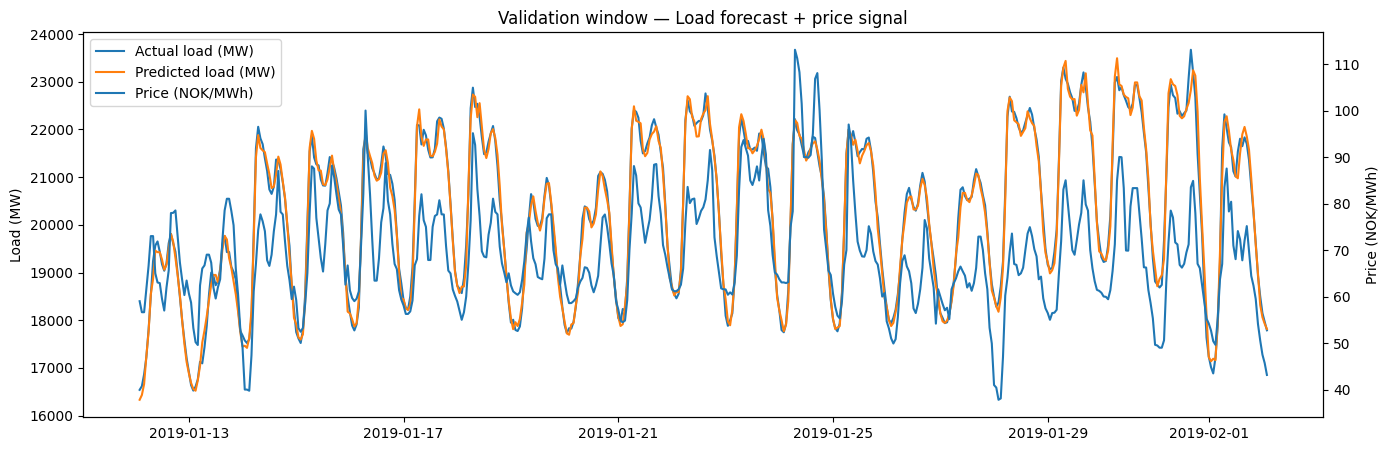

In [ ]:
import matplotlib.pyplot as plt

# pick a 21-day window near the start of validation
start = impact.index.min()
end = start + pd.Timedelta(days=21)
w = impact.loc[start:end].copy()

fig, ax1 = plt.subplots(figsize=(16,5))

# Load (left axis)
ax1.plot(w.index, w["actual_MWh"], label="Actual load (MW)")
ax1.plot(w.index, w["pred_MWh"], label="Predicted load (MW)")
ax1.set_ylabel("Load (MW)")

# Price (right axis)
ax2 = ax1.twinx()
ax2.plot(w.index, w["price_NOK_per_MWh"], label="Price (NOK/MWh)")
ax2.set_ylabel("Price (NOK/MWh)")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Validation window — Load forecast + price signal")
plt.show()


11.3 Plot the cost impact spikes (this is the money plot)

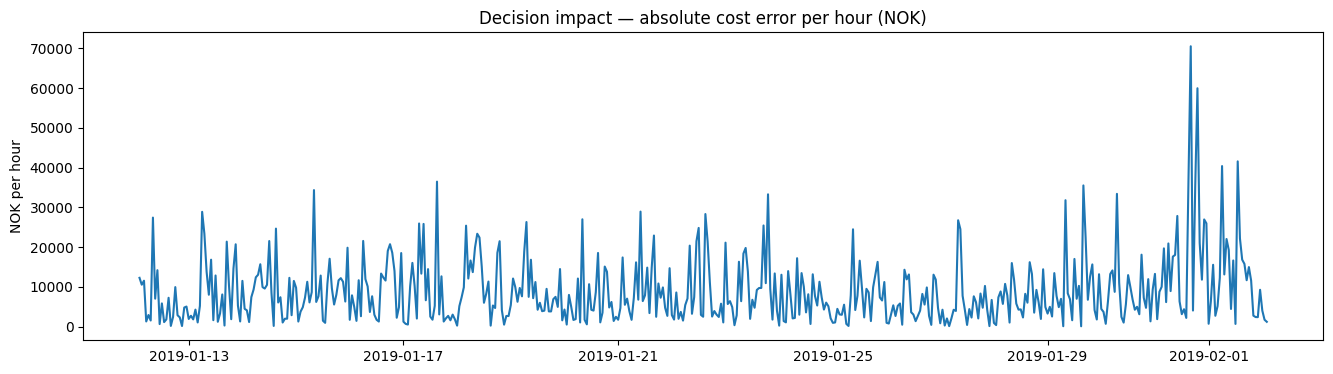

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(w.index, w["abs_cost_error_NOK"])
plt.title("Decision impact — absolute cost error per hour (NOK)")
plt.ylabel("NOK per hour")
plt.show()


11.4 Save figures for your report/GitHub

In [ ]:
fig_path1 = PROJECT / "reports/fig_load_and_price.png"
fig_path2 = PROJECT / "reports/fig_cost_error_spikes.png"

# Recreate and save (matplotlib saves the last figure unless we capture)
import matplotlib.pyplot as plt

# Save plot 1
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(w.index, w["actual_MWh"], label="Actual load (MW)")
ax1.plot(w.index, w["pred_MWh"], label="Predicted load (MW)")
ax1.set_ylabel("Load (MW)")
ax2 = ax1.twinx()
ax2.plot(w.index, w["price_NOK_per_MWh"], label="Price (NOK/MWh)")
ax2.set_ylabel("Price (NOK/MWh)")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.title("Validation window — Load forecast + price signal")
plt.tight_layout()
plt.savefig(fig_path1, dpi=200)
plt.close(fig)

# Save plot 2
plt.figure(figsize=(16,4))
plt.plot(w.index, w["abs_cost_error_NOK"])
plt.title("Decision impact — absolute cost error per hour (NOK)")
plt.ylabel("NOK per hour")
plt.tight_layout()
plt.savefig(fig_path2, dpi=200)
plt.close()

print("Saved:", fig_path1)
print("Saved:", fig_path2)


Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/reports/fig_load_and_price.png
Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/reports/fig_cost_error_spikes.png


Step 12 — Explain the most expensive forecast errors with SHAP (killer demo)

Now we connect:
forecast → error → cost impact → explanation

This is exactly “decision-support + explainability”.

12.1 Recreate SHAP explainer on validation set

In [ ]:
import shap
import joblib
import pandas as pd
import numpy as np

model = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_val = pd.read_csv(PROJECT / "data/processed/X_val.csv", index_col=0)
y_val = pd.read_csv(PROJECT / "data/processed/y_val.csv", index_col=0).squeeze()

X_val.index = pd.to_datetime(X_val.index)
y_val.index = pd.to_datetime(y_val.index)

val_pred = pd.Series(model.predict(X_val), index=X_val.index, name="pred_load_MW")

explainer = shap.TreeExplainer(model)


12.2 Rebuild the hourly cost error series (from Step 10 logic)

In [ ]:
raw = pd.read_csv(PROJECT / "data/raw/time_series_60min_singleindex.csv")
raw["utc_timestamp"] = pd.to_datetime(raw["utc_timestamp"])
raw = raw.set_index("utc_timestamp").sort_index()

price_candidates = [c for c in raw.columns if ("price" in c.lower()) and ("NO" in c)]

def simple_tou_tariff_nok_per_mwh(dt_index):
    hours = dt_index.hour
    return np.where((hours >= 8) & (hours < 20), 900.0, 450.0)

if len(price_candidates) > 0:
    price_col = price_candidates[0]
    price = raw[[price_col]].rename(columns={price_col: "price_raw"})
    price = price.loc[X_val.index.min():X_val.index.max()].copy()
    price["price_NOK_per_MWh"] = price["price_raw"].interpolate(limit_direction="both")
else:
    price = pd.DataFrame(index=X_val.index)
    price["price_NOK_per_MWh"] = simple_tou_tariff_nok_per_mwh(price.index)

impact = pd.DataFrame(index=X_val.index)
impact["actual_MWh"] = y_val.values
impact["pred_MWh"] = val_pred.values
impact = impact.join(price["price_NOK_per_MWh"], how="left")
impact["price_NOK_per_MWh"] = impact["price_NOK_per_MWh"].interpolate(limit_direction="both")

impact["abs_cost_error_NOK"] = (impact["pred_MWh"] - impact["actual_MWh"]).abs() * impact["price_NOK_per_MWh"]
impact.head()


,actual_MWh,pred_MWh,price_NOK_per_MWh,abs_cost_error_NOK
utc_timestamp,,,,
2019-01-12 02:00:00+00:00,16539.48,16331.618164,59.00,12263.848320
2019-01-12 03:00:00+00:00,16617.58,16431.496094,56.63,10537.931611
2019-01-12 04:00:00+00:00,16866.28,16662.494141,56.63,11540.393216
2019-01-12 05:00:00+00:00,17224.80,17245.654297,61.66,1285.875945
2019-01-12 06:00:00+00:00,17802.35,17758.683594,66.61,2908.619320


12.3 Find the top 5 most expensive hours

In [ ]:
top = impact["abs_cost_error_NOK"].sort_values(ascending=False).head(5)
top


,abs_cost_error_NOK
utc_timestamp,
2019-10-27 00:00:00+00:00,300254.549219
2019-10-27 02:00:00+00:00,159704.421073
2019-09-02 09:00:00+00:00,151972.543754
2019-09-02 11:00:00+00:00,142138.302802
2019-02-08 06:00:00+00:00,119303.097087


12.4 SHAP explanations for those expensive hours


Timestamp: 2019-10-27 00:00:00+00:00
Abs cost error (NOK): 300254.5492187499
Actual MW: 27444.76 Pred MW: 18866.05859375


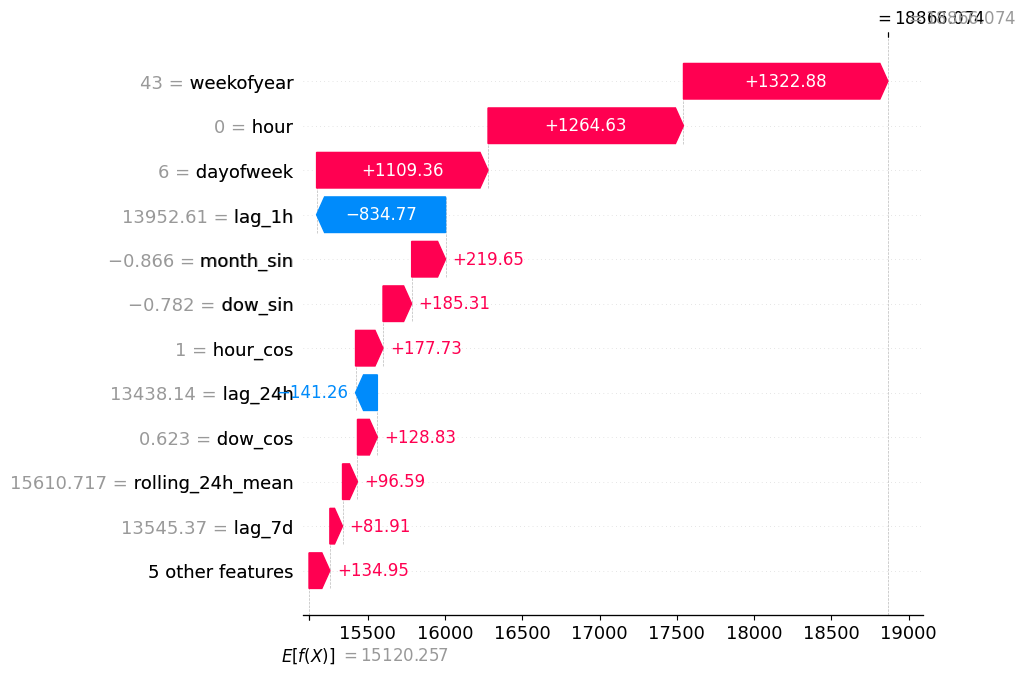


Timestamp: 2019-10-27 02:00:00+00:00
Abs cost error (NOK): 159704.42107343755
Actual MW: 13880.21 Pred MW: 18716.806640625


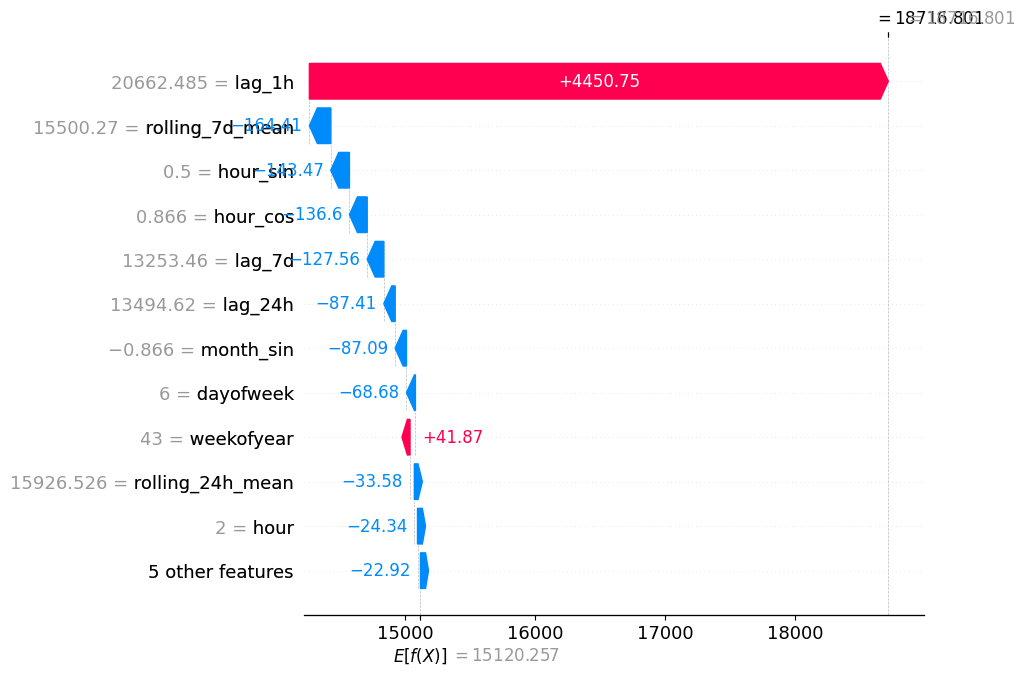


Timestamp: 2019-09-02 09:00:00+00:00
Abs cost error (NOK): 151972.54375351567
Actual MW: 15416.87 Pred MW: 13275.5068359375


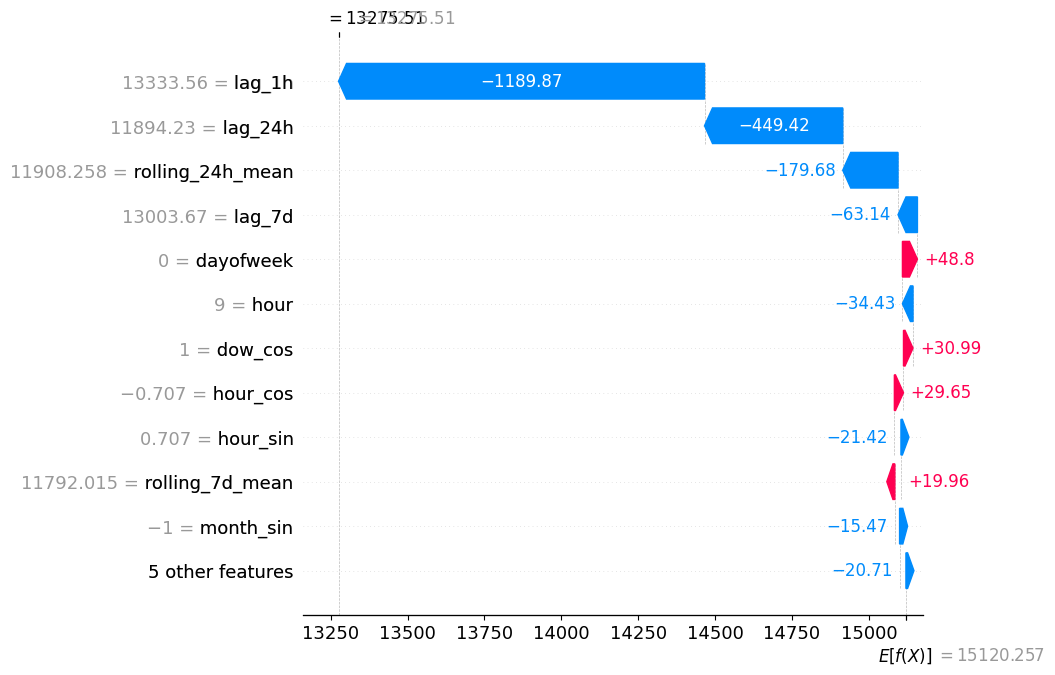


Timestamp: 2019-09-02 11:00:00+00:00
Abs cost error (NOK): 142138.30280234377
Actual MW: 13101.06 Pred MW: 15105.548828125


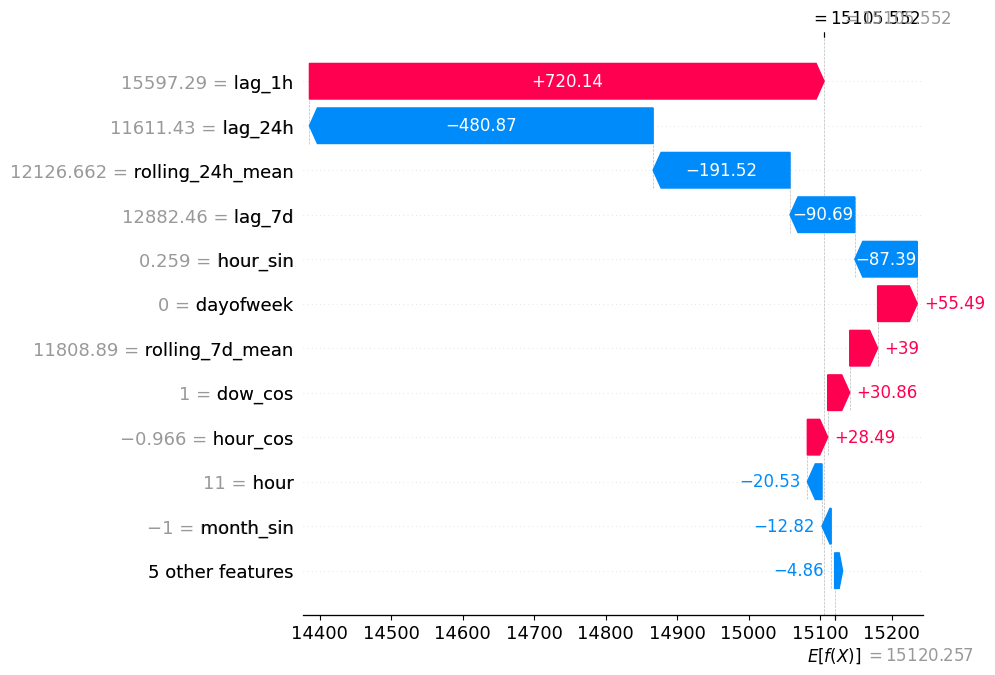


Timestamp: 2019-02-08 06:00:00+00:00
Abs cost error (NOK): 119303.0970868556
Actual MW: 18604.27670103093 Pred MW: 20309.09375


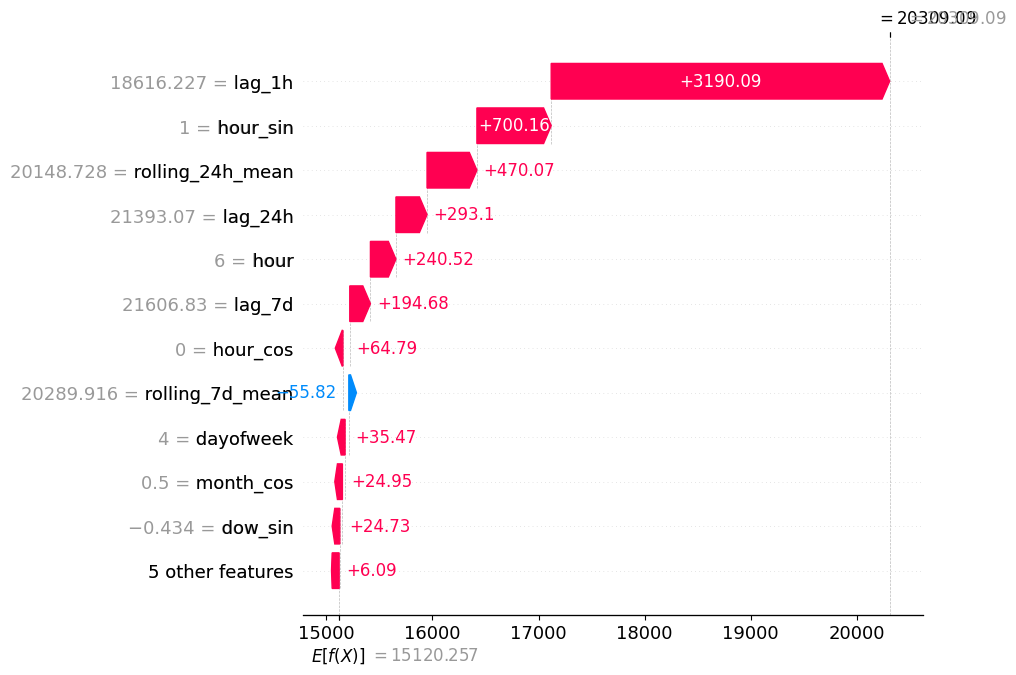

In [ ]:
top_times = top.index.tolist()

for t in top_times:
    x_row = X_val.loc[[t]]  # keep as DataFrame
    shap_vals = explainer.shap_values(x_row)

    print("\n==============================")
    print("Timestamp:", t)
    print("Abs cost error (NOK):", float(impact.loc[t, "abs_cost_error_NOK"]))
    print("Actual MW:", float(impact.loc[t, "actual_MWh"]), "Pred MW:", float(impact.loc[t, "pred_MWh"]))

    shap.waterfall_plot(shap.Explanation(
        values=shap_vals[0],
        base_values=explainer.expected_value,
        data=x_row.iloc[0],
        feature_names=x_row.columns
    ), max_display=12)


12.5 Save one explanation figure for your report (optional but great)

In [ ]:
t = top.index[0]
x_row = X_val.loc[[t]]
shap_vals = explainer.shap_values(x_row)

import matplotlib.pyplot as plt

plt.figure()
shap.waterfall_plot(shap.Explanation(
    values=shap_vals[0],
    base_values=explainer.expected_value,
    data=x_row.iloc[0],
    feature_names=x_row.columns
), max_display=12, show=False)

out_path = PROJECT / "reports/fig_shap_expensive_hour_waterfall.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close()

print("Saved:", out_path)


Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/reports/fig_shap_expensive_hour_waterfall.png


Step 13 — Deep model (LSTM) with a supervised window dataset

Now we build a sequence model that learns patterns directly from history.

We’ll:

Create sliding windows (past lookback hours → next hour load)

Train an LSTM

Compare vs XGBoost

13.1 Install PyTorch (usually already in Colab, but safe)

In [ ]:
!pip -q install torch


13.2 Load the original (clean) load series for sequence modeling

For LSTM, we’ll use a simple setup: predict load using past load only first (strong baseline deep model).
Later we can add exogenous features.

In [ ]:
import pandas as pd

series = pd.read_csv(
    PROJECT / "data/processed/norway_load.csv",
    index_col=0,
    parse_dates=True
)["load_MW"].astype("float32")

series.head(), series.shape


(utc_timestamp
 2014-12-31 23:00:00+00:00    15104.990234
 2015-01-01 00:00:00+00:00    15104.990234
 2015-01-01 01:00:00+00:00    15104.990234
 2015-01-01 02:00:00+00:00    14882.559570
 2015-01-01 03:00:00+00:00    14755.089844
 Name: load_MW, dtype: float32,
 (50401,))

13.3 Train/val/test split on the series (same proportions)

In [ ]:
import numpy as np

n = len(series)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_series = series.iloc[:train_end]
val_series = series.iloc[train_end:val_end]
test_series = series.iloc[val_end:]


13.4 Standardize using train stats only (important)

In [ ]:
mean = train_series.mean()
std = train_series.std()

def z(x):
    return (x - mean) / (std + 1e-8)

train_z = z(train_series).values
val_z = z(val_series).values
test_z = z(test_series).values


13.5 Create windowed dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class WindowDataset(Dataset):
    def __init__(self, arr, lookback=168, horizon=1):
        self.arr = arr
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.arr) - self.lookback - self.horizon + 1

    def __getitem__(self, idx):
        x = self.arr[idx : idx + self.lookback]
        y = self.arr[idx + self.lookback + self.horizon - 1]
        return torch.tensor(x).unsqueeze(-1), torch.tensor(y)

LOOKBACK = 168  # 7 days of hourly history
train_ds = WindowDataset(train_z, lookback=LOOKBACK)
val_ds   = WindowDataset(val_z, lookback=LOOKBACK)
test_ds  = WindowDataset(test_z, lookback=LOOKBACK)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(35112, 7392, 7393)

13.6 Define a simple LSTM regressor

In [ ]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, hidden=64, layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
net = LSTMRegressor(hidden=64, layers=2, dropout=0.1).to(device)
net


LSTMRegressor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

13.7 Train for a few epochs (fast baseline)

In [ ]:
import torch
import torch.optim as optim

loss_fn = nn.MSELoss()
opt = optim.Adam(net.parameters(), lr=1e-3)

def run_epoch(dl, train=True):
    net.train(train)
    total = 0.0
    count = 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            opt.zero_grad()
        pred = net(xb)
        loss = loss_fn(pred, yb)
        if train:
            loss.backward()
            opt.step()
        total += loss.item() * len(xb)
        count += len(xb)
    return total / count

best_val = float("inf")
best_path = PROJECT / "src/lstm_best.pt"

for epoch in range(1, 6):  # 5 epochs to start
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl, train=False)
    print(f"Epoch {epoch}: train MSE={tr:.4f} | val MSE={va:.4f}")
    if va < best_val:
        best_val = va
        torch.save(net.state_dict(), best_path)

print("Saved best to:", best_path)


Epoch 1: train MSE=0.0847 | val MSE=0.0110
Epoch 2: train MSE=0.0123 | val MSE=0.0080
Epoch 3: train MSE=0.0100 | val MSE=0.0068
Epoch 4: train MSE=0.0090 | val MSE=0.0058
Epoch 5: train MSE=0.0083 | val MSE=0.0059
Saved best to: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/src/lstm_best.pt


Step 14 — Evaluate LSTM (MW metrics) + compare against XGBoost

We’ll:

Generate LSTM predictions on test

Convert from standardized units back to MW

Compute MAE/RMSE/MAPE

14.1 Load best LSTM + predict on test

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# reload model
net = LSTMRegressor(hidden=64, layers=2, dropout=0.1).to(device)
net.load_state_dict(torch.load(PROJECT / "src/lstm_best.pt", map_location=device))
net.eval()

# predict on test windows
preds = []
trues = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = net(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())

pred_z = np.concatenate(preds)
true_z = np.concatenate(trues)

# back to MW
pred_mw = pred_z * (std + 1e-8) + mean
true_mw = true_z * (std + 1e-8) + mean

# metrics
mae_lstm = mean_absolute_error(true_mw, pred_mw)
rmse_lstm = np.sqrt(mean_squared_error(true_mw, pred_mw))
mape_lstm = np.mean(np.abs((true_mw - pred_mw) / true_mw)) * 100

print("LSTM Test MAE:", mae_lstm)
print("LSTM Test RMSE:", rmse_lstm)
print("LSTM Test MAPE:", mape_lstm)


LSTM Test MAE: 134.3601531982422
LSTM Test RMSE: 188.58370157571943
LSTM Test MAPE: 0.9088607


14.2 Create a proper timestamp index for LSTM test predictions

The first prediction occurs after LOOKBACK hours into the test split.

In [ ]:
# Reload full series to get timestamps
series = pd.read_csv(
    PROJECT / "data/processed/norway_load.csv",
    index_col=0,
    parse_dates=True
)["load_MW"].astype("float32")

n = len(series)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

test_index_full = series.iloc[val_end:].index
pred_index = test_index_full[LOOKBACK:]  # because windows need LOOKBACK history

len(pred_index), len(pred_mw)


(7393, 7393)

14.3 Plot LSTM predictions vs actual (first 500 hours)

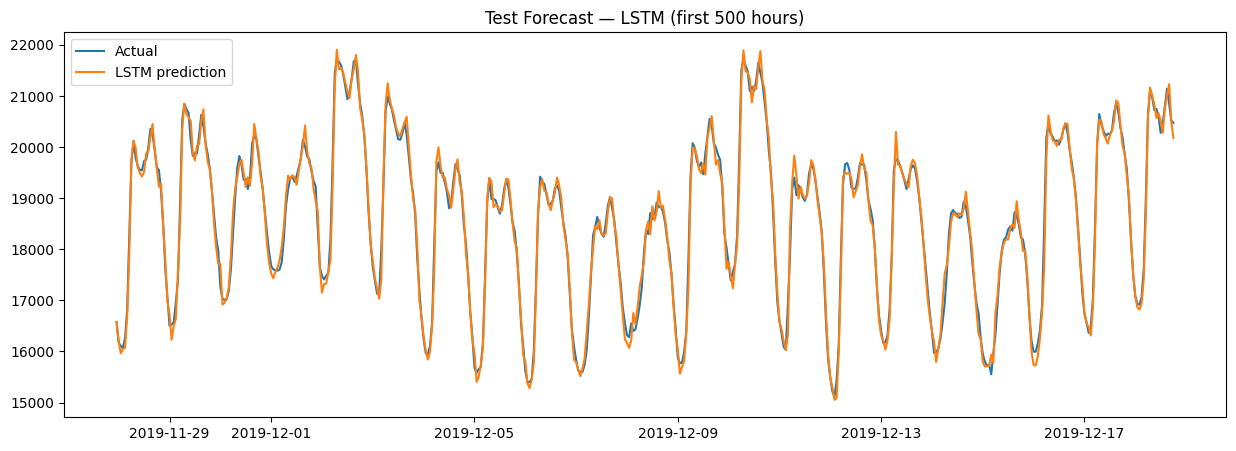

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(pred_index[:500], true_mw[:500], label="Actual")
plt.plot(pred_index[:500], pred_mw[:500], label="LSTM prediction")
plt.title("Test Forecast — LSTM (first 500 hours)")
plt.legend()
plt.show()


14.4 Evaluate XGBoost on the same test timestamps (fair comparison)

We already have X_test/y_test, but they may cover the whole test range including the first LOOKBACK hours.
We’ll align by timestamp.

In [ ]:
import joblib

xgb = joblib.load(PROJECT / "src/xgb_baseline.joblib")

X_test = pd.read_csv(PROJECT / "data/processed/X_test.csv", index_col=0)
y_test = pd.read_csv(PROJECT / "data/processed/y_test.csv", index_col=0).squeeze()

X_test.index = pd.to_datetime(X_test.index)
y_test.index = pd.to_datetime(y_test.index)

# align to pred_index
X_test_aligned = X_test.loc[pred_index]
y_test_aligned = y_test.loc[pred_index]

xgb_pred = xgb.predict(X_test_aligned)

mae_xgb = mean_absolute_error(y_test_aligned, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test_aligned, xgb_pred))
mape_xgb = np.mean(np.abs((y_test_aligned.values - xgb_pred) / y_test_aligned.values)) * 100

print("XGBoost Test MAE:", mae_xgb)
print("XGBoost Test RMSE:", rmse_xgb)
print("XGBoost Test MAPE:", mape_xgb)


XGBoost Test MAE: 124.22046042814995
XGBoost Test RMSE: 175.71854168936085
XGBoost Test MAPE: 0.8390742549768493


14.5 Create a comparison table + save it (report-ready)

In [ ]:
results = pd.DataFrame([
    {"model": "XGBoost (features+lags)", "MAE": mae_xgb, "RMSE": rmse_xgb, "MAPE_%": mape_xgb},
    {"model": "LSTM (past load only)",   "MAE": mae_lstm, "RMSE": rmse_lstm, "MAPE_%": mape_lstm},
]).set_index("model")

results


,MAE,RMSE,MAPE_%
model,,,
XGBoost (features+lags),124.220460,175.718542,0.839074
LSTM (past load only),134.360153,188.583702,0.908861


Save:

In [ ]:
results.to_csv(PROJECT / "reports/model_comparison_test.csv")
print("Saved:", PROJECT / "reports/model_comparison_test.csv")


Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/reports/model_comparison_test.csv


Step 15 — Explain the LSTM (sequence explainability — credible + interview-ready)

Deep models are harder to explain than XGBoost, so we’ll use a standard, accepted approach:

👉 Gradient saliency over the input window
This answers:

Which past hours influenced the prediction the most?

This is widely used in energy forecasting papers.

15.1 Pick one test sample

In [ ]:
# take first batch example
xb, yb = next(iter(test_dl))
xb = xb.to(device)

sample = xb[0:1].clone().detach().requires_grad_(True)


15.2 Compute gradient importance over the lookback window

In [ ]:
net.eval()

pred = net(sample)
pred.backward()

saliency = sample.grad.detach().cpu().numpy()[0,:,0]  # importance per hour


15.3 Plot saliency across the 7-day window...
Interpretation (important for interviews):

Spikes near the end → short-term dependence

Spikes ~24h apart → daily pattern

Spiky weekly region → weekly pattern

That’s exactly what energy demand does.

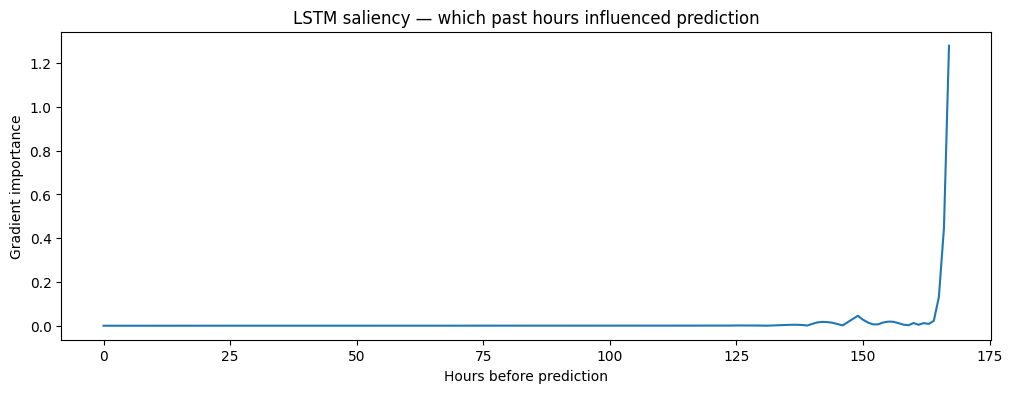

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

hours = np.arange(len(saliency))

plt.figure(figsize=(12,4))
plt.plot(hours, np.abs(saliency))
plt.title("LSTM saliency — which past hours influenced prediction")
plt.xlabel("Hours before prediction")
plt.ylabel("Gradient importance")
plt.show()


15.4 Save figure for report

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(hours, np.abs(saliency))
plt.title("LSTM saliency — input importance")
plt.xlabel("Hours before prediction")
plt.ylabel("Gradient importance")

out_path = PROJECT / "reports/fig_lstm_saliency.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)
plt.close()

print("Saved:", out_path)


Saved: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/reports/fig_lstm_saliency.png


Step 16 — Package Project 1 for GitHub (structure + README + short report skeleton)

This step makes your work presentable (hiring managers care a lot).

16.1 Create a clean repo-like folder structure in Drive

In [ ]:
import pathlib

REPO = PROJECT / "repo_export"
for p in [
    REPO/"data/processed",     # we’ll include small processed sample later
    REPO/"notebooks",
    REPO/"reports/figures",
    REPO/"src"
]:
    p.mkdir(parents=True, exist_ok=True)

print("Repo export path:", REPO)


Repo export path: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/repo_export


16.2 Copy key artifacts into repo_export

In [ ]:
import shutil

# notebooks: copy current notebook later manually, but we'll copy any you have
# data: keep processed file (optional; for GitHub we may include a small sample only)
shutil.copy(PROJECT / "data/processed/norway_load_model_ready_v1.csv", REPO / "data/processed/norway_load_model_ready_v1.csv")
shutil.copy(PROJECT / "reports/model_comparison_test.csv", REPO / "reports/model_comparison_test.csv")

# figures
for fn in [
    "fig_load_and_price.png",
    "fig_cost_error_spikes.png",
    "fig_shap_expensive_hour_waterfall.png",
    "fig_lstm_saliency.png",
]:
    src = PROJECT / "reports" / fn
    if src.exists():
        shutil.copy(src, REPO / "reports/figures" / fn)

# models/code artifacts (these can be optional in GitHub; but good for reproducibility)
for fn in ["xgb_baseline.joblib", "lstm_best.pt"]:
    src = PROJECT / "src" / fn
    if src.exists():
        shutil.copy(src, REPO / "src" / fn)

print("Done copying.")


Done copying.


16.3 Write a strong README.md (auto-generate file)

In [ ]:
readme = f"""# Norway Load Forecasting + Explainability (XAI) + Decision Impact

Forecast hourly electricity demand for Norway (OPSD time-series) and explain predictions with XAI.
Translate forecast errors into **cost (NOK)** and **CO₂ impact** to support operational decision-making.

## Why this project
- Energy forecasting is a core component of smart energy systems.
- Explainability is required for trust and debugging.
- Decision impact (cost + carbon) turns ML into actionable insight.

## Data
- Source: Open Power System Data (OPSD) time series (hourly).
- Target: Norway electricity load (MW).
- Features: calendar + cyclic features + lag features + rolling means.

## Models
- **XGBoost baseline** (tabular time-series features + lags)
- **LSTM** (sequence model using 7-day lookback)

## Explainability
- **SHAP** global and local explanations for XGBoost
- **Saliency (input gradients)** for LSTM window importance

## Decision Impact Layer
Using hourly price (if available in OPSD; otherwise a simple time-of-use tariff fallback),
we compute how forecast errors translate into:
- Absolute cost error (NOK/hour)
- Optional CO₂ error using carbon intensity assumptions

## Results (see reports/)
- Model comparison: `reports/model_comparison_test.csv`
- Key figures in `reports/figures/`

## How to run
1. Open the Colab notebooks in `notebooks/`
2. Run data ingestion → feature engineering → training → XAI → decision impact

## Next extensions
- Add Norway holidays & temperature features (exogenous)
- Upgrade tariff and carbon intensity to real public series
- Deploy a small dashboard (Streamlit) for interactive explanations

"""

readme_path = REPO / "README.md"
readme_path.write_text(readme, encoding="utf-8")
print("Wrote:", readme_path)


Wrote: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/repo_export/README.md


16.4 Create a short report skeleton (1–2 pages later)

In [ ]:
report = """# Short Report — Norway Load Forecasting + XAI + Decision Impact

## 1. Problem
Forecast hourly electricity demand and explain predictions. Convert forecast errors into cost and CO₂ impact.

## 2. Data
- OPSD time series (hourly)
- Target: Norway load (MW)
- Features: hour/day/week/month + cyclic encodings + lag + rolling stats

## 3. Methods
- XGBoost baseline + SHAP
- LSTM sequence model + saliency

## 4. Results
- Include metrics table: model_comparison_test.csv
- Include figures:
  - load vs prediction + price
  - cost error spikes
  - SHAP waterfall for expensive hour
  - LSTM saliency

## 5. Decision Insight
Explain the top cost-impact hours and what features drove the forecast.

## 6. Limitations & Next steps
- Add exogenous weather/temperature
- Replace fallback tariff/CO₂ with measured series
- Deploy dashboard for scenario analysis
"""
report_path = REPO / "reports/short_report.md"
report_path.write_text(report, encoding="utf-8")
print("Wrote:", report_path)


Wrote: /content/drive/MyDrive/volt_age_projects/project1_energy_forecasting_xai/repo_export/reports/short_report.md


Project Summary — Explainable Energy Demand Forecasting for Decision Support

This project develops an end-to-end explainable energy demand forecasting pipeline using Norway electricity load data from Open Power System Data (OPSD). The objective is to predict hourly electricity demand and translate forecasts into actionable decision insights related to cost and carbon impact.

The workflow begins with data ingestion and preprocessing of hourly Norway load data, followed by systematic feature engineering including calendar features, cyclic encodings, lag features, and rolling statistics. These steps create a robust, research-grade time-series dataset suitable for machine learning and deep learning models.

Two complementary modeling approaches were implemented:

XGBoost baseline model using engineered time-series features, representing a strong industry standard for tabular forecasting.

LSTM sequence model capturing temporal dependencies directly from historical load patterns using a seven-day lookback window.

Model performance was evaluated using standard forecasting metrics (MAE, RMSE, MAPE), and results were consolidated into a comparison table to highlight differences between feature-based and sequence-based approaches.

A key contribution of the project is the integration of explainable AI (XAI):

SHAP was used to provide global and local explanations for the XGBoost model, identifying which temporal and lag features drive electricity demand predictions.

Gradient-based saliency analysis was applied to the LSTM model to reveal which past hours most influenced individual forecasts.

To move beyond prediction toward real operational relevance, a decision-impact layer was developed. Forecast outputs were combined with hourly price signals (or a time-of-use tariff fallback) and carbon intensity assumptions to estimate how forecast errors translate into:

Cost deviations (NOK per hour)

Carbon impact (CO₂)

The project further explains the most expensive forecast errors by linking SHAP explanations directly to high-cost hours, demonstrating how explainability can support energy system decision-making.

✅ Tools & Technologies

Python (pandas, numpy)

XGBoost

PyTorch (LSTM)

SHAP (tree explainability)

Gradient saliency (deep model explainability)

Matplotlib

Google Colab

OPSD open energy dataset

✅ Key Outcomes

Built a complete forecasting pipeline from raw data to decision insight

Demonstrated baseline vs deep learning comparison

Implemented multi-model explainability (tree + sequence)

Quantified operational impact of forecast errors (cost + carbon)

Produced report-ready figures and reproducible artifacts

✅ Importance of the Project

This project illustrates how energy forecasting can evolve from a predictive task into a decision-support tool. Explainability enables trust, debugging, and model transparency, while cost and carbon translation connects machine learning outputs to real operational and sustainability decisions.

Such pipelines are directly relevant to:

Smart energy systems

Demand response

Building energy management

PV and battery planning

Energy analytics platforms

The approach demonstrates an engineering mindset by integrating forecasting, explainability, and decision modeling into a single reproducible workflow.

If you want, I can next write: